In [1]:
# Parameters
SAMPLES = "VIB_Hydrop_2,VIB_Hydrop_1"
METADATAPKL = "benchmark__metadata.pickle"
PROFDATAPKL = "benchmark__profile_data.pickle"
WORKFLOW_PARAMETERS = "{\"container\":\"/staging/leuven/stg_00002/lcb/cflerin/containers/aertslab-pycistopic-latest.sif\",\"biomart_annot\":{\"biomart_dataset_name\":\"hsapiens_gene_ensembl\",\"biomart_host\":\"http://www.ensembl.org\"},\"macs2_call_peaks\":{\"gsize\":\"hs\",\"qvalue\":0.01,\"extsize\":146,\"shift\":73,\"keepdup\":\"all\"},\"compute_qc_stats\":{\"n_frag\":100,\"tss_flank_window\":2000,\"tss_window\":50,\"tss_minimum_signal_window\":100,\"tss_rolling_window\":10,\"min_norm\":0.1},\"call_cells\":{\"report_ipynb\":\"/src/pycistopic/bin/pycisTopic_qc_report_template.ipynb\",\"use_density_coloring_on_scatterplot\":true,\"use_detailed_title_on_scatterplot\":true,\"filter_frags_upper\":\"\",\"filter_tss_lower\":{\"Broad_1\":18,\"Broad_2\":18,\"Broad_mito_1\":12,\"Broad_mito_2\":12,\"CNAG_1\":15,\"CNAG_2\":15,\"Sanger_1\":13,\"Sanger_2\":13,\"VIB_1\":18,\"VIB_2\":15,\"Stanford_1\":12,\"Stanford_2\":12,\"atac_pbmc_5k_v1\":16,\"atac_pbmc_5k_nextgem\":16,\"pbmc_unsorted_3k\":15,\"s3atac\":4,\"VIB_Hydrop_1\":15,\"VIB_Hydrop_2\":15},\"filter_tss_upper\":\"\",\"filter_frip_lower\":\"\",\"filter_frip_upper\":\"\",\"filter_frags_lower\":{\"Broad_1\":3000,\"Broad_2\":3000,\"Broad_mito_1\":3500,\"Broad_mito_2\":3500,\"CNAG_1\":2000,\"CNAG_2\":2500,\"Sanger_1\":6000,\"Sanger_2\":6000,\"VIB_1\":4000,\"VIB_2\":4000,\"Stanford_1\":9000,\"Stanford_2\":6000,\"atac_pbmc_5k_v1\":3000,\"atac_pbmc_5k_nextgem\":3000,\"pbmc_unsorted_3k\":2000,\"s3atac\":10000,\"VIB_Hydrop_1\":1000,\"VIB_Hydrop_2\":1000},\"filter_dup_rate_lower\":\"\",\"filter_dup_rate_upper\":\"\"}}"


# VSN Pipelines: pycisTopic QC report

scATAC-seq quality control and cell calling from pycisTopic (https://github.com/aertslab/pycisTopic)

In [2]:
import pycisTopic
pycisTopic.__version__

'0.1.dev300+g7494158'

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [4]:
import pybiomart as pbm
import pandas as pd
import pickle
import re
import os
import json

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

In [5]:
params = json.loads(WORKFLOW_PARAMETERS)

sample_ids = SAMPLES.split(',')

print(f"SAMPLES: {sample_ids}")
print(f"pycisTopic parameters: {json.dumps(params, indent=4)}")

SAMPLES: ['VIB_Hydrop_2', 'VIB_Hydrop_1']
pycisTopic parameters: {
    "container": "/staging/leuven/stg_00002/lcb/cflerin/containers/aertslab-pycistopic-latest.sif",
    "biomart_annot": {
        "biomart_dataset_name": "hsapiens_gene_ensembl",
        "biomart_host": "http://www.ensembl.org"
    },
    "macs2_call_peaks": {
        "gsize": "hs",
        "qvalue": 0.01,
        "extsize": 146,
        "shift": 73,
        "keepdup": "all"
    },
    "compute_qc_stats": {
        "n_frag": 100,
        "tss_flank_window": 2000,
        "tss_window": 50,
        "tss_minimum_signal_window": 100,
        "tss_rolling_window": 10,
        "min_norm": 0.1
    },
    "call_cells": {
        "report_ipynb": "/src/pycistopic/bin/pycisTopic_qc_report_template.ipynb",
        "use_density_coloring_on_scatterplot": true,
        "use_detailed_title_on_scatterplot": true,
        "filter_frags_upper": "",
        "filter_tss_lower": {
            "Broad_1": 18,
            "Broad_2": 18,
      

In [6]:
# Load metadata
infile = open(METADATAPKL, 'rb')
metadata_bc_dict = pickle.load(infile)
infile.close()

In [7]:
# Load profile data
infile = open(PROFDATAPKL, 'rb')
profile_data_dict = pickle.load(infile)
infile.close()

## QC summary

In [8]:
from pycisTopic.qc import plot_sample_metrics
from scipy.stats import gaussian_kde

### Per-sample metrics

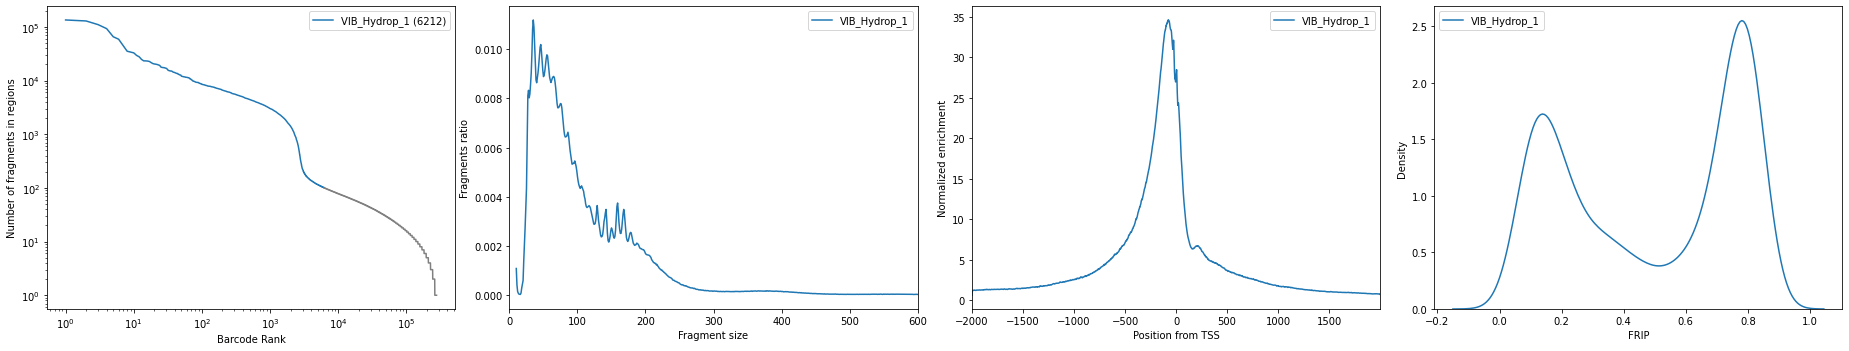

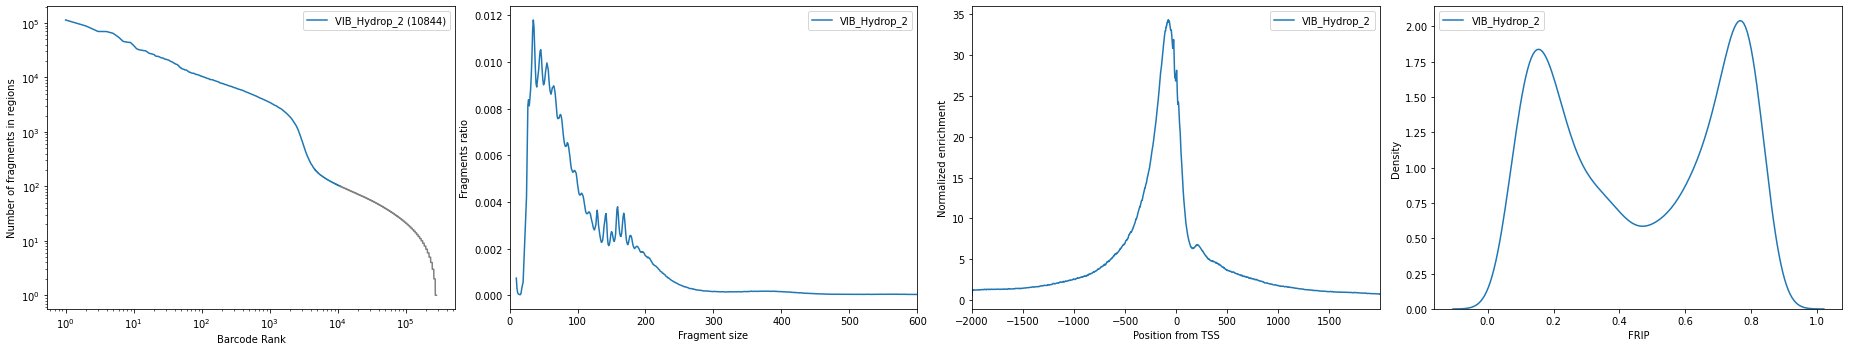

In [9]:
for sample_id in profile_data_dict:
    plot_sample_metrics({sample_id: profile_data_dict[sample_id]},
               profile_list=['barcode_rank_plot', 'insert_size_distribution', 'profile_tss', 'frip'],
               insert_size_distriubtion_xlim=[0,600],
               ncol=4,
               cmap='tab20',
               plot=True)
plt.show()

### Combined sample metrics

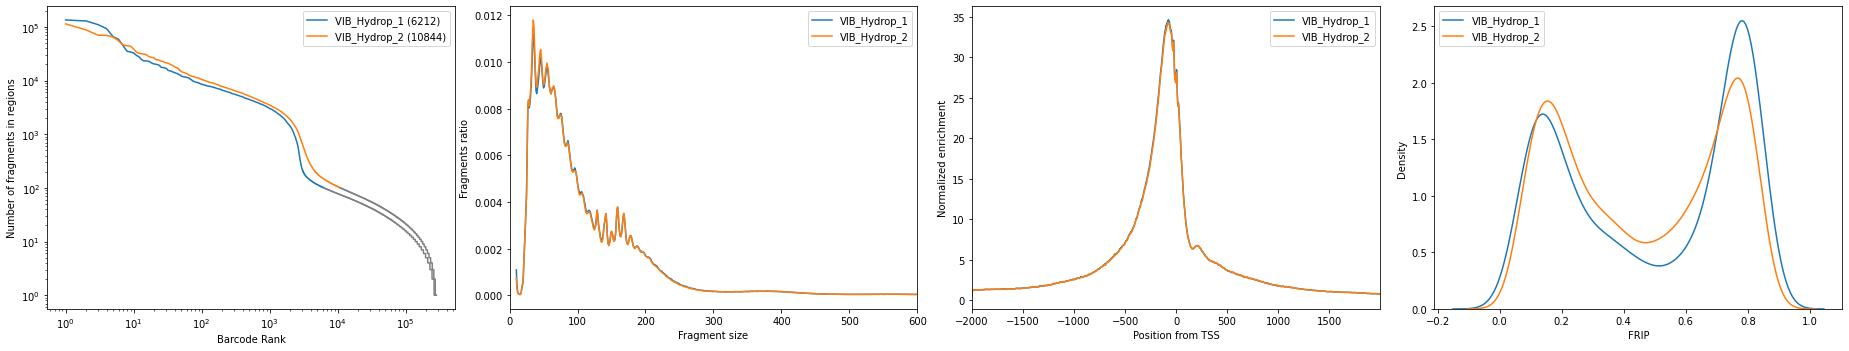

In [10]:
plot_sample_metrics(profile_data_dict,
           profile_list=['barcode_rank_plot', 'insert_size_distribution', 'profile_tss', 'frip'],
           insert_size_distriubtion_xlim=[0,600],
           ncol=4,
           cmap='tab20',
           plot=True)
plt.show()

## Cell calling

In [11]:
def plot_frag_qc(x, y, 
                 ax,
                 x_thr_min=None, x_thr_max=None,
                 y_thr_min=None, y_thr_max=None,
                 ylab=None,
                 xlab="Number of (unique) fragments",
                 cmap='viridis',
                 density_overlay=False,
                 s=10,
                 marker='+',
                 c='#343434',
                 xlim=None,
                 ylim=None,
                 **kwargs
                ):
    assert all(x.index == y.index)
    barcodes = x.index.values
    if density_overlay:
        xy = np.vstack([np.log(x),y])
        z = gaussian_kde(xy)(xy)
        idx = z.argsort()
        x, y, z, barcodes = x[idx], y[idx], z[idx], barcodes[idx]
    else:
        z=c
    barcodes_to_keep=[]
    sp=ax.scatter(x, y, c=z, s=s, edgecolors=None, marker=marker, cmap=cmap, **kwargs)
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])
    # thresholds:
    if x_thr_min is not None:    
        ax.axvline(x=x_thr_min, color='r', linestyle='--')
        barcodes_to_keep.append(barcodes[x>x_thr_min])
    if x_thr_max is not None:    
        ax.axvline(x=x_thr_max, color='r', linestyle='--')
        barcodes_to_keep.append(barcodes[x<x_thr_max])
    if y_thr_min is not None:    
        ax.axhline(y=y_thr_min, color='r', linestyle='--')
        barcodes_to_keep.append(barcodes[y>y_thr_min])
    if y_thr_max is not None:    
        ax.axhline(y=y_thr_max, color='r', linestyle='--')
        barcodes_to_keep.append(barcodes[y<y_thr_max])
    ax.set_xscale("log")
    ax.set_xmargin(0.01)
    ax.set_ymargin(0.01)
    ax.set_xlabel(xlab,fontsize=10)
    ax.set_ylabel(ylab,fontsize=10)
    #return barcodes_to_keep
    if len(barcodes_to_keep)>0:
        return list(set.intersection(*map(set, barcodes_to_keep)))
    else:
        return barcodes

In [12]:
# extract filter thresholds from Nextflow parameters
filter_frags_lower = {}
filter_frags_upper = {}
filter_tss_lower = {}
filter_tss_upper = {}
filter_frip_lower = {}
filter_frip_upper = {}
filter_dup_rate_lower = {}
filter_dup_rate_upper = {}

def float_or_none(x):
    try:
        return float(x)
    except ValueError:
        return None
    
def extract_sample_specific_param(filter_dict, sample_id, param_key):
    if type(params['call_cells'][param_key]) is dict:
        if sample_id in params['call_cells'][param_key]:
            filter_dict[sample_id] = float_or_none(params['call_cells'][param_key][sample_id])
        else:
            try:
                filter_dict[sample_id] = float_or_none(params['call_cells'][param_key]['default'])
            except KeyError:
                print(f"WARNING: Missing 'default' key in the sample parameters list. Filter for '{param_key}' will be missing for sample '{sample_id}'.")
                filter_dict[sample_id] = None
    else:
        filter_dict[sample_id] = float_or_none(params['call_cells'][param_key])
    return filter_dict

for s in sample_ids:
    filter_frags_lower = extract_sample_specific_param(filter_frags_lower, s, 'filter_frags_lower')
    filter_frags_upper = extract_sample_specific_param(filter_frags_upper, s, 'filter_frags_upper')
    #
    filter_tss_lower = extract_sample_specific_param(filter_tss_lower, s, 'filter_tss_lower')
    filter_tss_upper = extract_sample_specific_param(filter_tss_upper, s, 'filter_tss_upper')
    #
    filter_frip_lower = extract_sample_specific_param(filter_frip_lower, s, 'filter_frip_lower')
    filter_frip_upper = extract_sample_specific_param(filter_frip_upper, s, 'filter_frip_upper')
    #
    filter_dup_rate_lower = extract_sample_specific_param(filter_dup_rate_lower, s, 'filter_dup_rate_lower')
    filter_dup_rate_upper = extract_sample_specific_param(filter_dup_rate_upper, s, 'filter_dup_rate_upper')


In [13]:
# show cell filters:
print(f"Filter parameters:")
print(f"filter_frags_lower: {json.dumps(filter_frags_lower, indent=4)}")
print(f"filter_frags_upper: {json.dumps(filter_frags_upper, indent=4)}")
print(f"filter_tss_lower: {json.dumps(filter_tss_lower, indent=4)}")
print(f"filter_tss_upper: {json.dumps(filter_tss_upper, indent=4)}")
print(f"filter_frip_lower: {json.dumps(filter_frip_lower, indent=4)}")
print(f"filter_frip_upper: {json.dumps(filter_frip_upper, indent=4)}")
print(f"filter_dup_rate_lower: {json.dumps(filter_dup_rate_lower, indent=4)}")
print(f"filter_dup_rate_upper: {json.dumps(filter_dup_rate_upper, indent=4)}")

Filter parameters:
filter_frags_lower: {
    "VIB_Hydrop_2": 1000.0,
    "VIB_Hydrop_1": 1000.0
}
filter_frags_upper: {
    "VIB_Hydrop_2": null,
    "VIB_Hydrop_1": null
}
filter_tss_lower: {
    "VIB_Hydrop_2": 15.0,
    "VIB_Hydrop_1": 15.0
}
filter_tss_upper: {
    "VIB_Hydrop_2": null,
    "VIB_Hydrop_1": null
}
filter_frip_lower: {
    "VIB_Hydrop_2": null,
    "VIB_Hydrop_1": null
}
filter_frip_upper: {
    "VIB_Hydrop_2": null,
    "VIB_Hydrop_1": null
}
filter_dup_rate_lower: {
    "VIB_Hydrop_2": null,
    "VIB_Hydrop_1": null
}
filter_dup_rate_upper: {
    "VIB_Hydrop_2": null,
    "VIB_Hydrop_1": null
}


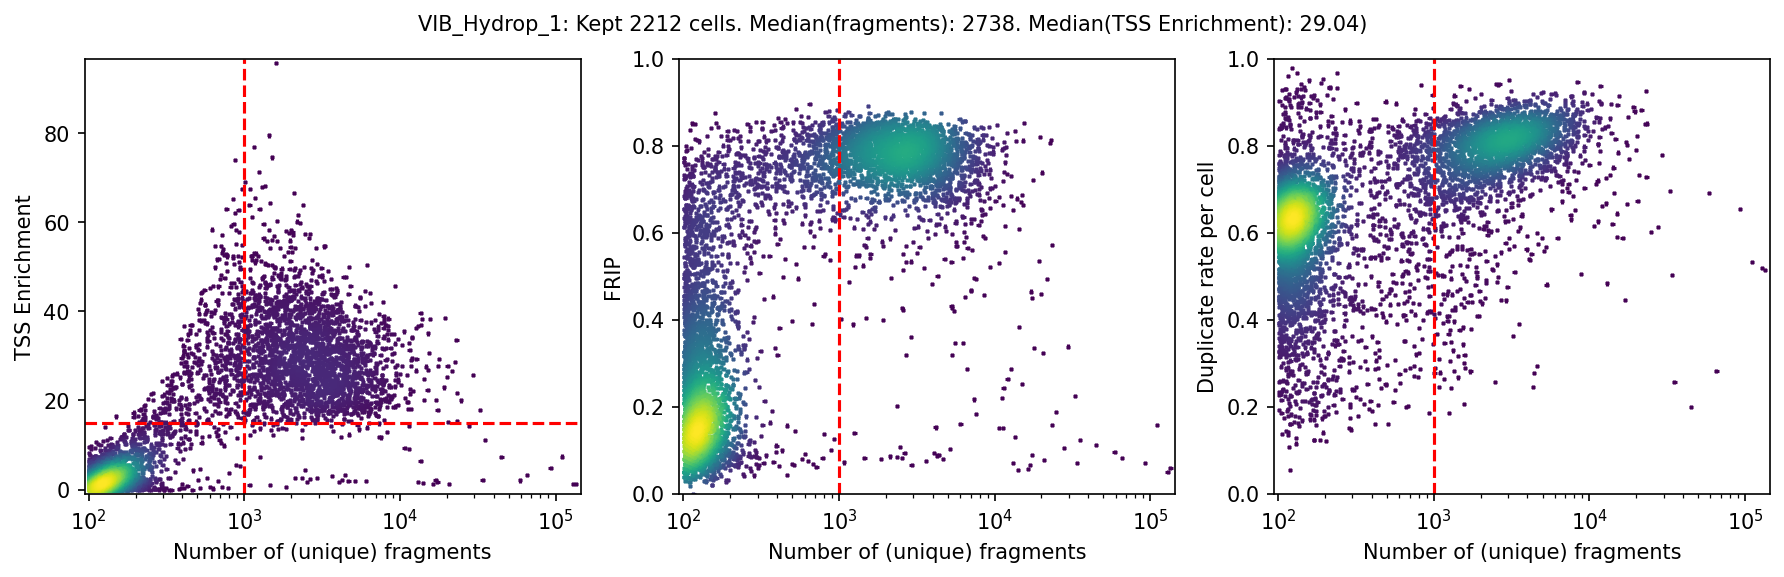

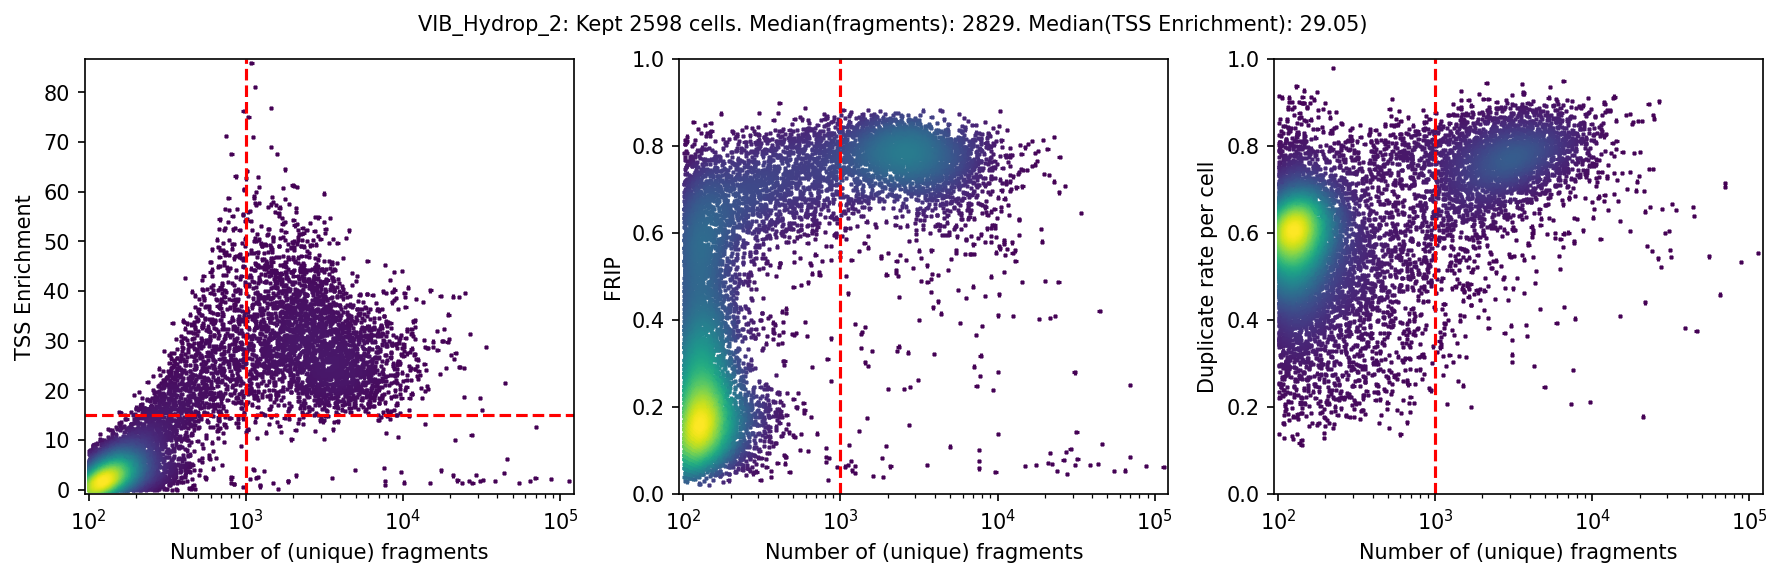

In [14]:
include_kde = params['call_cells']['use_density_coloring_on_scatterplot']
detailed_title=params['call_cells']['use_detailed_title_on_scatterplot']
s=4
bc_passing_filters = {}
for k,v in metadata_bc_dict.items():

    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4), dpi=150 )
    p1_cells = plot_frag_qc(
        x = metadata_bc_dict[k]['Unique_nr_frag'],
        y = metadata_bc_dict[k]['TSS_enrichment'],
        ylab = 'TSS Enrichment',
        s=s,
        x_thr_min=filter_frags_lower[k],
        y_thr_min=filter_tss_lower[k],
        density_overlay=include_kde,
        ax=ax1
    )
    p2_cells = plot_frag_qc(
        x = metadata_bc_dict[k]['Unique_nr_frag'],
        y = metadata_bc_dict[k]['FRIP'],
        x_thr_min=filter_frags_lower[k],
        ylab = 'FRIP',
        s=s,
        ylim=[0,1],
        density_overlay=include_kde,
        ax=ax2
    )
    p3_cells = plot_frag_qc(
        x = metadata_bc_dict[k]['Unique_nr_frag'],
        y = metadata_bc_dict[k]['Dupl_rate'],
        x_thr_min=filter_frags_lower[k],
        ylab = 'Duplicate rate per cell',
        s=s,
        ylim=[0,1],
        density_overlay=include_kde,
        ax=ax3
    )
    bc_passing_filters[k] = list(set(p1_cells) & set(p2_cells) & set(p3_cells))
    if detailed_title:
        med_nf = metadata_bc_dict[k].loc[bc_passing_filters[k],'Unique_nr_frag'].median()
        med_tss = metadata_bc_dict[k].loc[bc_passing_filters[k],'TSS_enrichment'].median()
        title = f"{k}: Kept {len(bc_passing_filters[k])} cells. Median(fragments): {med_nf:.0f}. Median(TSS Enrichment): {med_tss:.2f})"
    else:
        title = k
    fig.suptitle(title, x=0.5, y=0.95, fontsize=10)
    plt.tight_layout()

plt.show()

In [15]:
with open('bc_passing_filters.pkl', 'wb') as f:
  pickle.dump(bc_passing_filters, f)

In [16]:
# write all barcodes selected in compute_qc_stats (with nFrag>x)
if not os.path.exists('selected_barcodes_nFrag'):
    os.makedirs('selected_barcodes_nFrag')
    
for k,v in metadata_bc_dict.items():
    pd.DataFrame(v.index).to_csv('selected_barcodes_nFrag/'+k+'.barcodes_nFrag_thr.txt', sep='\t', header=False, index=False)

In [17]:
# write all cell barcodes selected by filtering
if not os.path.exists('selected_barcodes'):
    os.makedirs('selected_barcodes')
    
for k,v in bc_passing_filters.items():
    pd.DataFrame(v).to_csv('selected_barcodes/'+k+'.cell_barcodes.txt', sep='\t', header=False, index=False)

#### pycisTopic barcode metrics plots

In [18]:
from pycisTopic.qc import plot_barcode_metrics
from pycisTopic.utils import fig2img

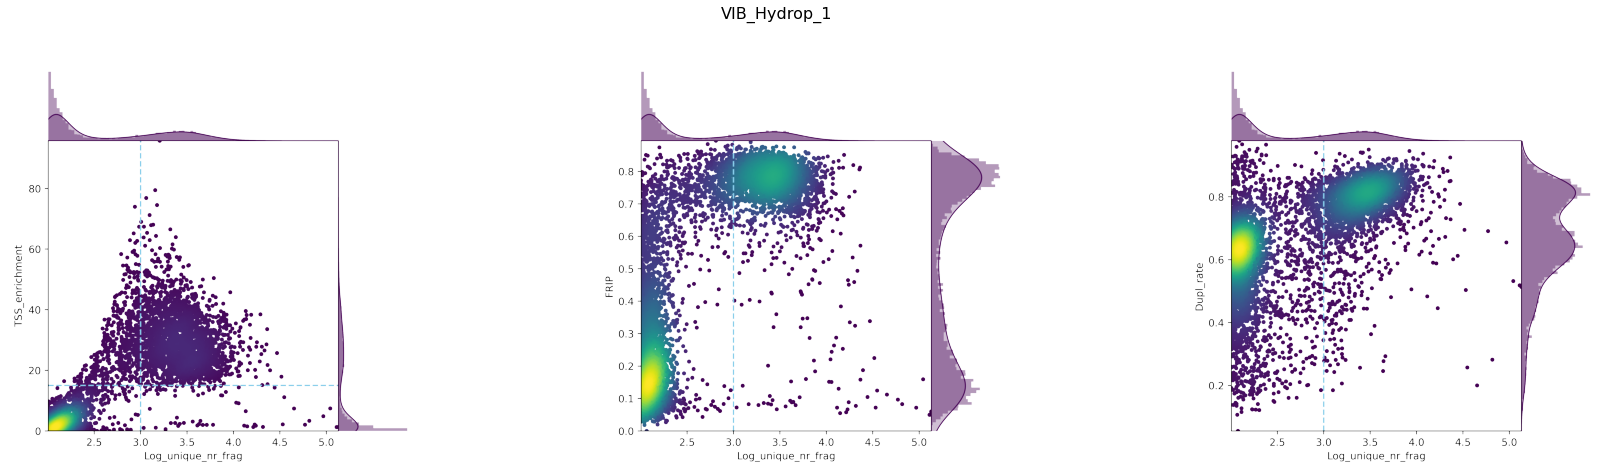

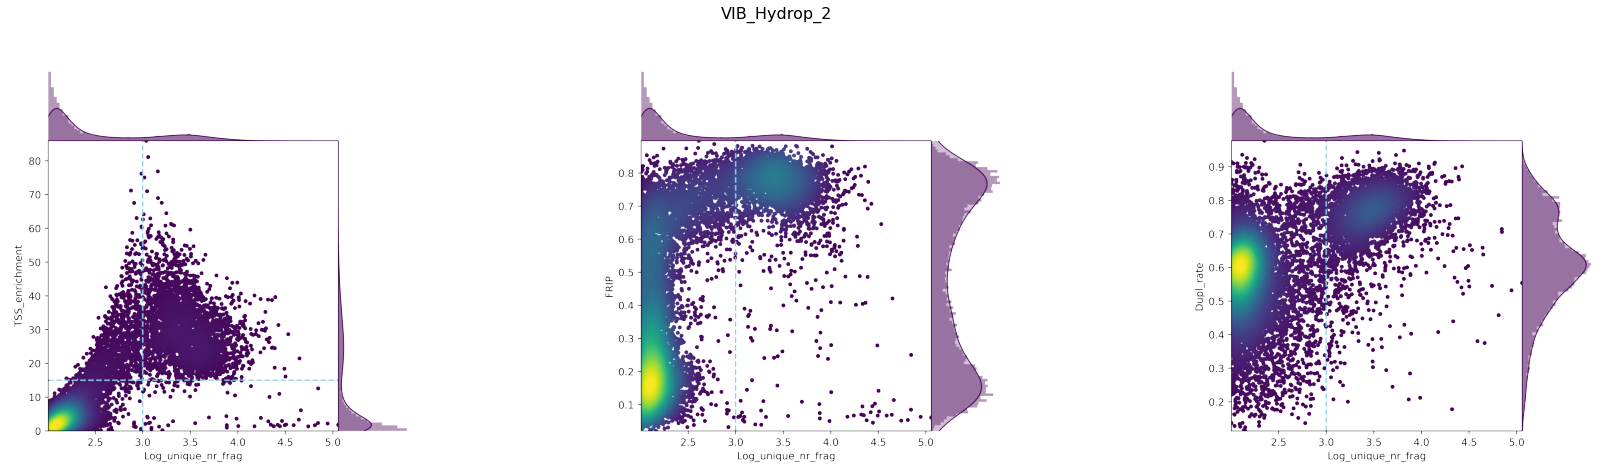

In [19]:
def none_or_log10(x):
    return None if x is None else np.log10(x)

for k,v in metadata_bc_dict.items():

    FRIP_NR_FRAG_fig = plot_barcode_metrics(metadata_bc_dict[k],
                                            var_x='Log_unique_nr_frag',
                                            var_y='FRIP',
                                            min_x=none_or_log10(filter_frags_lower[k]),
                                            max_x=none_or_log10(filter_frags_upper[k]),
                                            min_y=filter_frip_lower[k],
                                            max_y=filter_frip_upper[k],
                                            return_cells=False,
                                            return_fig=True,
                                            plot=False,
                                            )

    TSS_NR_FRAG_fig = plot_barcode_metrics(metadata_bc_dict[k],
                                           var_x='Log_unique_nr_frag',
                                           var_y='TSS_enrichment',
                                           min_x=none_or_log10(filter_frags_lower[k]),
                                           max_x=none_or_log10(filter_frags_upper[k]),
                                           min_y=filter_tss_lower[k],
                                           max_y=filter_tss_upper[k],
                                           return_cells=False,
                                           return_fig=True,
                                           plot=False
                                           )

    DR_NR_FRAG_fig = plot_barcode_metrics(metadata_bc_dict[k],
                                          var_x='Log_unique_nr_frag',
                                          var_y='Dupl_rate',
                                          min_x=none_or_log10(filter_frags_lower[k]),
                                          max_x=none_or_log10(filter_frags_upper[k]),
                                          min_y=filter_dup_rate_lower[k],
                                          max_y=filter_dup_rate_upper[k],
                                          return_cells=False,
                                          return_fig=True,
                                          plot=False
                                          )
    fig=plt.figure(figsize=(30,7.5))
    plt.subplot(1, 3, 1)
    img = fig2img(TSS_NR_FRAG_fig)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    img = fig2img(FRIP_NR_FRAG_fig)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    img = fig2img(DR_NR_FRAG_fig)
    plt.imshow(img)
    plt.axis('off')
    fig.suptitle(k, fontsize=16)
    plt.show()

## Summary

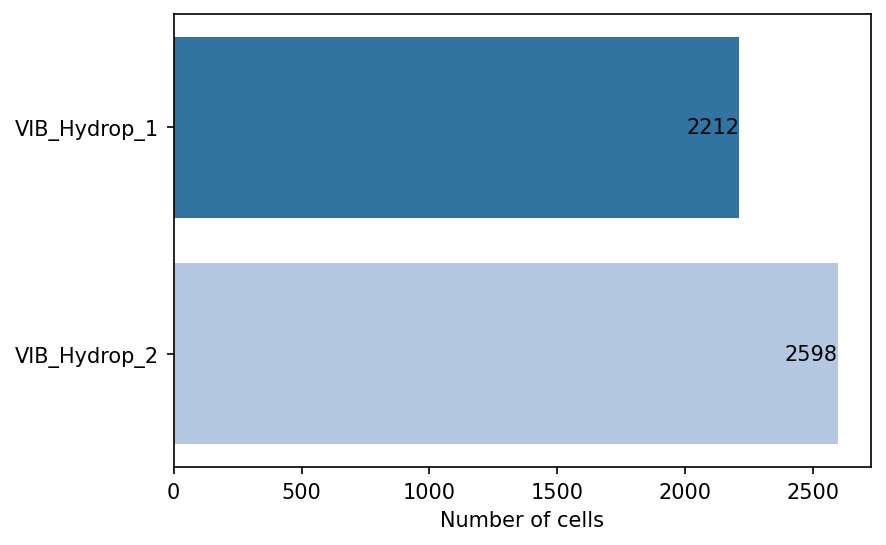

In [20]:
tp = pd.DataFrame([
    list(bc_passing_filters),
    [ len(bc_passing_filters[x]) for x in bc_passing_filters ]

]).T

fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=150 )
g=sns.barplot(x=1, y=0, data=tp,
           palette='tab20')
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width,           # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}'.format(width), # set variable to display, 2 decimals
            ha = 'right',   # horizontal alignment
            va = 'center')  # vertical alignment
ax.set_xlabel("Number of cells",fontsize=10)
ax.set_ylabel("",fontsize=10)
plt.show()
plt.tight_layout()

In [21]:
from matplotlib import ticker as mticker
import matplotlib.gridspec as gridspec
import math

In [22]:
def plot_stats_violin(
    data,
    ax,
    var = 'Unique_nr_frag',
    ylab='Number of (unique) fragments',
    xlab='',
    logscale=True,
    **kwargs
    ):

    tp = []
    for k,v in data.items():
        tmp = pd.DataFrame(np.log10(data[k][var])) if logscale else pd.DataFrame(data[k][var])
        tmp['Sample'] = k
        tp.append(tmp)
    tp = pd.concat(tp, join='outer', axis=0)

    yrange = [ int(math.floor(tp[var].min())), int(math.ceil(tp[var].max())) ]
    
    g = sns.violinplot(data=tp, x='Sample', y=var,
                       dodge=True,
                       linewidth=0.5,
                       inner='quartiles',
                       ax=ax, kind='kde',
                       **kwargs)
    
    ax.set_xlabel(xlab,fontsize=10)
    ax.set_ylabel(ylab,fontsize=10)
    g.set_xticklabels(g.get_xticklabels(), rotation=15, ha='right', fontsize=8)

    plt.tight_layout()

<Figure size 432x288 with 0 Axes>

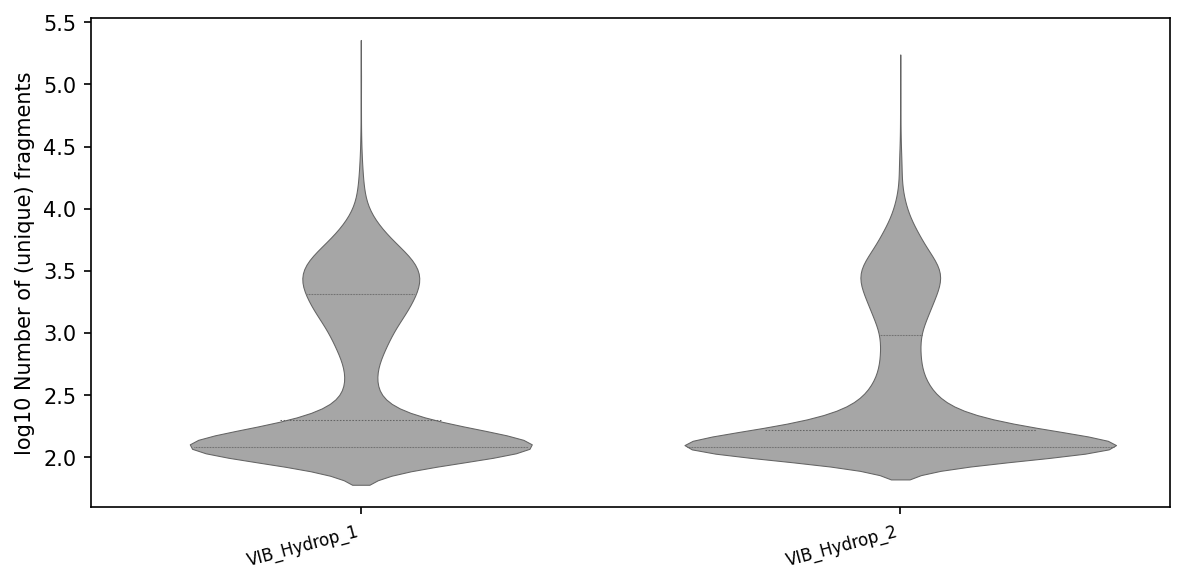

In [23]:
fig, ax1 = plt.subplots(1,1, figsize=(8,4), dpi=150 )

plot_stats_violin(
    metadata_bc_dict,
    ax=ax1,
    split=False,
    #palette='tab20',
    color="#a6a6a6",
    ylab='log10 Number of (unique) fragments',
    var='Unique_nr_frag')

plt.show()
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

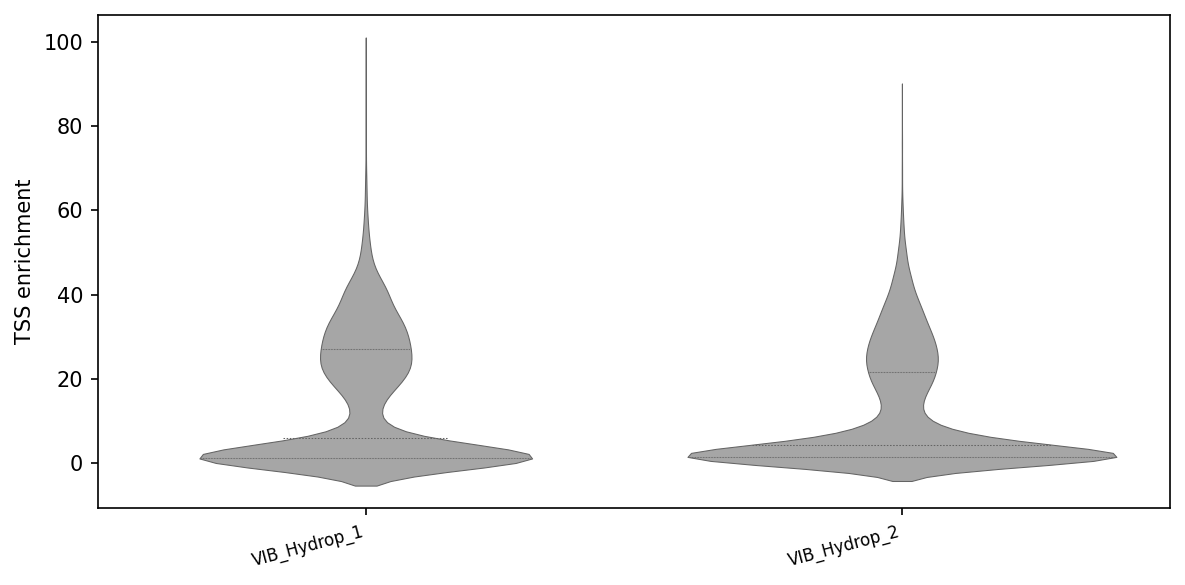

In [24]:
fig, ax1 = plt.subplots(1,1, figsize=(8,4), dpi=150 )

plot_stats_violin(
    metadata_bc_dict,
    ax=ax1,
    split=False,
    #palette='tab20',
    color="#a6a6a6",
    logscale=False,
    ylab='TSS enrichment',
    var='TSS_enrichment')

plt.show()
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

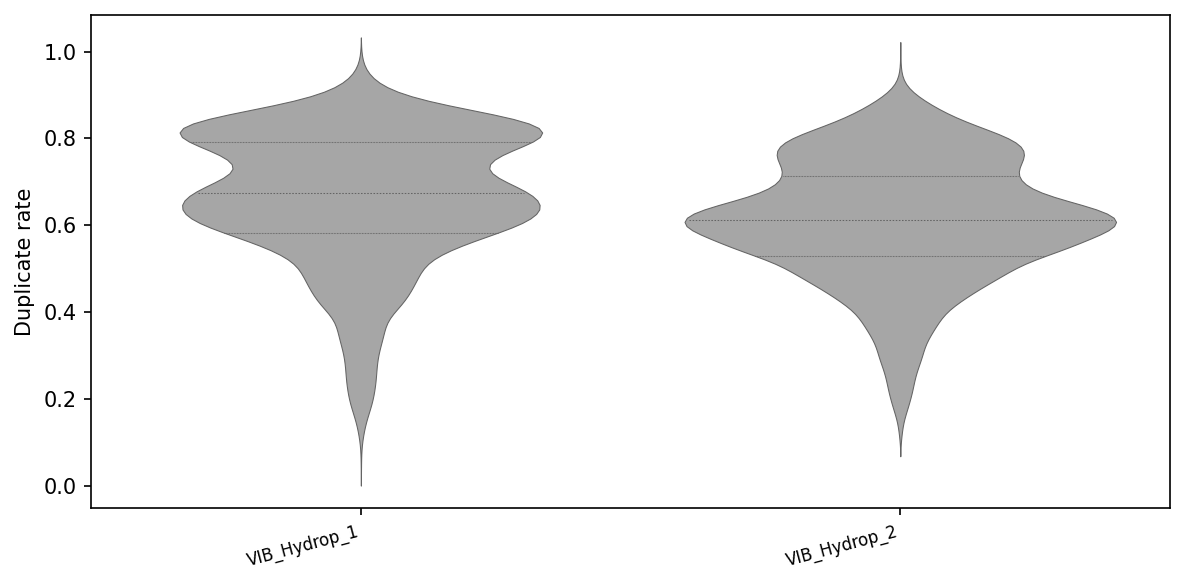

In [25]:
fig, ax1 = plt.subplots(1,1, figsize=(8,4), dpi=150 )

plot_stats_violin(
    metadata_bc_dict,
    ax=ax1,
    split=False,
    #palette='tab20',
    color="#a6a6a6",
    logscale=False,
    ylab='Duplicate rate',
    var='Dupl_rate')

plt.show()
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

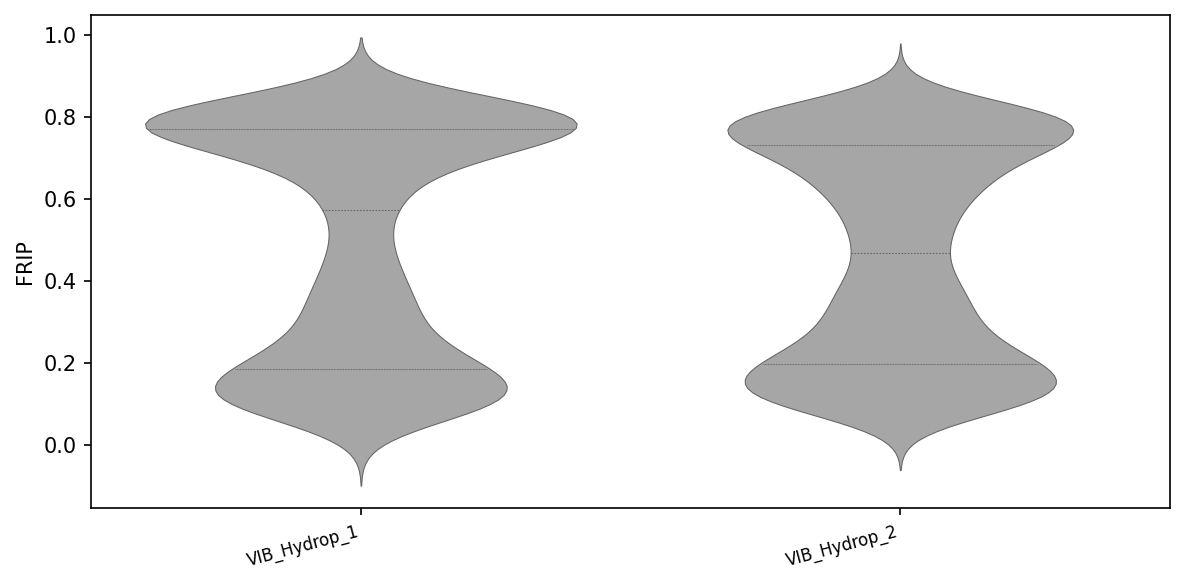

In [26]:
fig, ax1 = plt.subplots(1,1, figsize=(8,4), dpi=150 )

plot_stats_violin(
    metadata_bc_dict,
    ax=ax1,
    split=False,
    #alette='tab20',
    color="#a6a6a6",
    logscale=False,
    ylab='FRIP',
    var='FRIP')

plt.show()
plt.tight_layout()